In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, LSTM
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm

In [5]:
#!unzip /content/tmp.zip

# Use LSTM model to make prediction

In [6]:
df = pd.read_csv('/content/tmp/data_origin.csv/part-00000-6cf2e280-a147-4300-a46c-9d14b77e7126-c000.csv')
df.head()

,Date,Open,High,Low,Close
0,12/10/2012,1418.07,1421.64,1415.64,1418.55
1,12/07/2012,1413.95,1420.34,1410.90,1418.07
2,12/06/2012,1409.43,1413.95,1405.93,1413.94
3,12/05/2012,1407.05,1415.56,1398.23,1409.28
4,12/04/2012,1409.46,1413.14,1403.65,1407.05


In [7]:
data = df.filter(['Close'])
dataset = data.values
training_data_len = int(np.ceil( len(dataset) * .95 ))
training_data_len

2619

In [8]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

train_data = scaled_data[0:int(training_data_len), :]
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

[array([0.04020173, 0.04006535, 0.03889189, 0.03756784, 0.03693422,
       0.03761898, 0.03952834, 0.03946299, 0.03775252, 0.03462992,
       0.03671828, 0.0375309 , 0.03238244, 0.03146754, 0.03120614,
       0.02353175, 0.02167069, 0.02228442, 0.02769427, 0.029257  ,
       0.02920585, 0.02854099, 0.0333769 , 0.04299758, 0.0398352 ,
       0.03896576, 0.04277028, 0.03838613, 0.03832363, 0.03861628,
       0.03741725, 0.03865606, 0.04454042, 0.04436141, 0.05122319,
       0.05223753, 0.05053559, 0.04633329, 0.04305441, 0.04426197,
       0.04418241, 0.04671686, 0.05080835, 0.05224322, 0.05237676,
       0.04941895, 0.0479301 , 0.0475721 , 0.04648672, 0.04832789,
       0.04439835, 0.04674812, 0.05109533, 0.05202159, 0.05205285,
       0.05227731, 0.05178577, 0.05231709, 0.05361841, 0.05197613])]
[0.04531893734905529]

[array([0.04020173, 0.04006535, 0.03889189, 0.03756784, 0.03693422,
       0.03761898, 0.03952834, 0.03946299, 0.03775252, 0.03462992,
       0.03671828, 0.0375309 , 0.03

In [9]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=1)

2559/2559 [==============================] - 105s 40ms/step - loss: 0.0017


In [10]:
test_data = scaled_data[training_data_len - 60: , :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

5/5 [==============================] - 2s 64ms/step


104.96657260091963

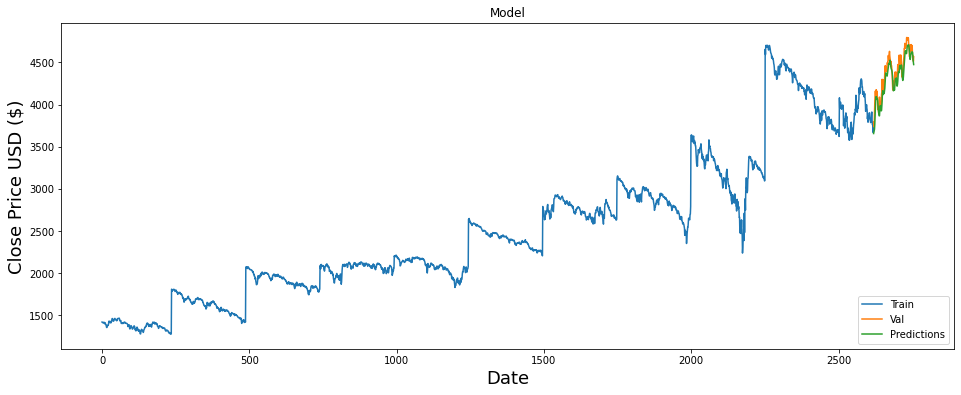

In [11]:
train = data.loc[:training_data_len]
valid = data.loc[training_data_len:]
valid['Predictions'] = predictions
# pr = pd.DataFrame(predictions, columns = ['predictions'])
# pr.to_csv('predictions.csv', encoding='utf-8', index=False)
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()